In [1]:
import os
import sys
import pandas as pd
sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())) + "/..")
if os.getcwd().endswith("Topic1"):
    os.chdir("..")
    print(f"Changed to {os.getcwd()}")
from codebase import read_all_punt_to_punt, make_detour_matrix

Changed to c:\Users\toell\Documents\GitHub\Design-of-AI-driven-business-operation


In [2]:
punten = ['basis', 'bus', 'hbo_wo', 'highschool', 'ibis', 'mbo', 'trein']
modes = ['fiets', 'ebike']

matrix_data = read_all_punt_to_punt(punten, modes)


Loading punt to punt data: 100%|██████████| 7/7 [00:50<00:00,  7.17s/it]


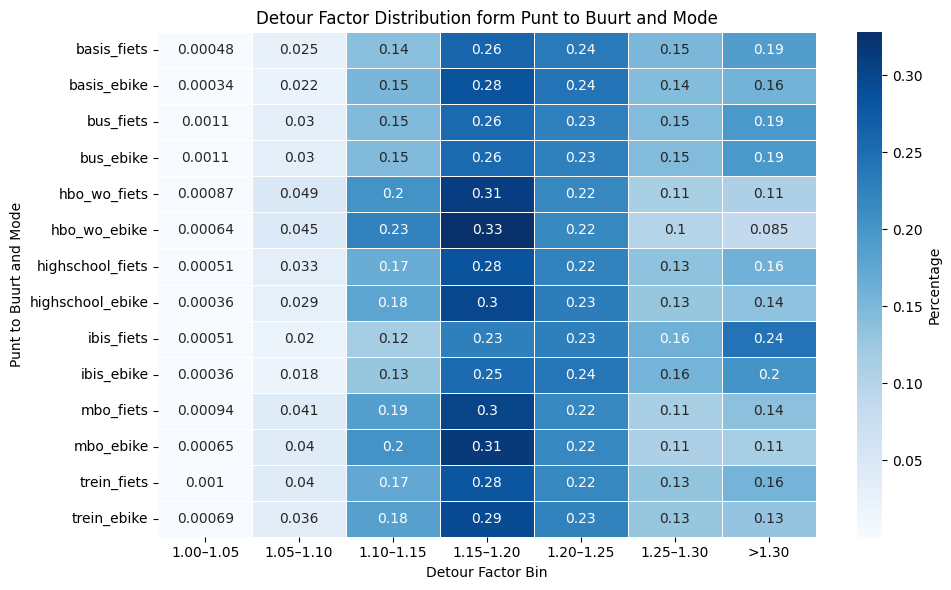

In [3]:
make_detour_matrix(matrix_data, savename="graphics/detour_matrix.png")

In [5]:
from pathlib import Path
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from codebase.buurt_calculations import read_all_punt_to_punt
from codebase import load_demograhics
# from codebase.buurt_calculations import load_municipality_geometry, weighted_detour_by_municipality

In [6]:

# ─────────────────────────────────────────────────────────────────────────────
def load_municipality_geometry(gpkg_path: Path) -> gpd.GeoDataFrame:
    """Return GeoDataFrame with columns ['gm_naam', 'geometry']."""
    gdf = gpd.read_file(gpkg_path, layer="gemeenten")
    if "gemeentenaam" not in gdf.columns:
        raise ValueError("'gemeentenaam' column not found in 'gemeenten' layer")
    gdf = gdf[["gemeentenaam", "geometry"]].rename(columns={"gemeentenaam": "gm_naam"})
    gdf["gm_naam"] = gdf["gm_naam"].str.title()
    return gdf


def weighted_detour_by_municipality(trips: pd.DataFrame,
                                    demo:  pd.DataFrame) -> pd.DataFrame:
    """
    Population-weighted mean detour factor per municipality.
    Returns DataFrame ['gm_naam', 'pop_weighted_detour'].
    """
    merged = (
        trips.merge(
            demo[["gwb_code", "gm_naam", "a_inw"]],
            left_on="bu_code", right_on="gwb_code",
            how="left", validate="many_to_one")
          .dropna(subset=["a_inw"])
    )

    w = (
        merged.groupby("gm_naam")
              .apply(lambda x: (x["omrijdfactor"] * x["a_inw"]).sum()
                               / x["a_inw"].sum())
              .reset_index(name="pop_weighted_detour")
    )
    w["gm_naam"] = w["gm_naam"].str.title()
    return w



Loading punt to punt data: 100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


Loaded file from CSV


C:\Users\toell\AppData\Local\Temp\ipykernel_22208\1385166883.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x["omrijdfactor"] * x["a_inw"]).sum()


CSV saved → data\detour_trein_fiets.csv
                gm_naam  pop_weighted_detour
144               Hulst             2.431832
268           Terneuzen             2.012440
269        Terschelling             1.846487
296            Vlieland             1.801895
14              Ameland             1.627701
249     Schiermonnikoog             1.605260
231         Reimerswaal             1.604377
46              Borsele             1.598054
148             Kapelle             1.499319
102  Goeree-Overflakkee             1.456277
250  Schouwen-Duiveland             1.434147
103                Goes             1.433284
309           Waterland             1.394955
83        Edam-Volendam             1.392916
272              Tholen             1.382385
10               Almere             1.367893
255               Sluis             1.358277
199      Noord-Beveland             1.338373
173           Maasdriel             1.331790
270               Texel             1.326435


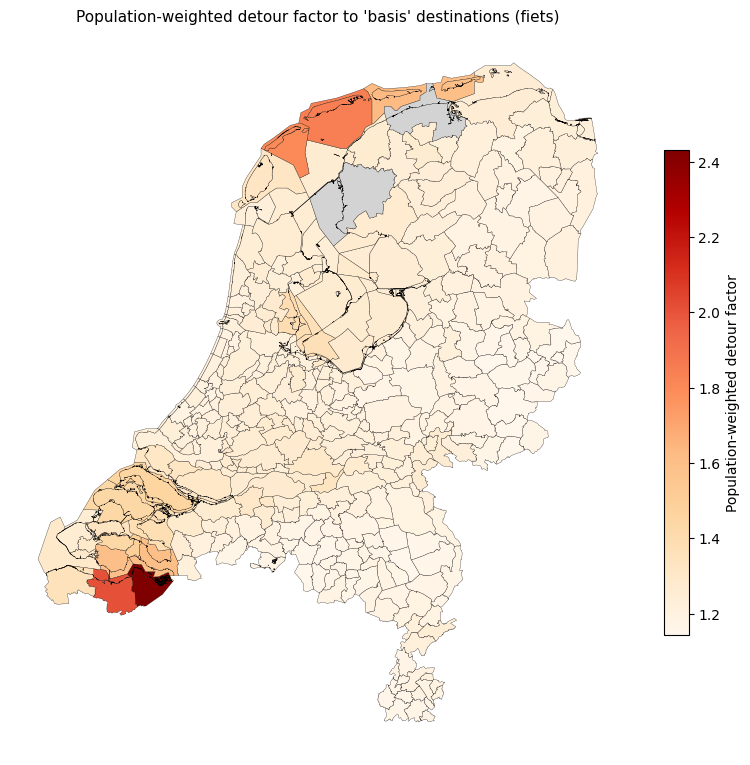

In [8]:


def main(
    category: str = "trein",
    modes: tuple[str, ...] = ("fiets",),
    gpkg:   Path = Path("data\WijkBuurtkaart_2023_v2\wijkenbuurten_2023_v2.gpkg"),
    out_csv: Path = Path("detour_result.csv"),
    top_n: int = 20,
    make_map: bool = True,
) -> None:
    # 1. load trip tables
    matrices = read_all_punt_to_punt([category], list(modes))
    if not matrices:
        raise FileNotFoundError("No matching punt→buurt files found")
    trips = pd.concat(matrices.values(), ignore_index=True)

    # 2. load demographics & compute statistics
    demo = load_demograhics()
    det  = weighted_detour_by_municipality(trips, demo)
    det.to_csv(out_csv, index=False)
    print(f"CSV saved → {out_csv}")
    print(det.nlargest(top_n, "pop_weighted_detour"))

    # 3. map
    if make_map:
        gdf = load_municipality_geometry(gpkg).merge(det, on="gm_naam", how="left")
        ax = gdf.plot(
            column="pop_weighted_detour",
            cmap="OrRd",
            linewidth=0.2,
            edgecolor="black",
            figsize=(8, 10),
            legend=True,
            #make legend smaller
            legend_kwds={"label": "Population-weighted detour factor", "shrink": 0.5},
            missing_kwds={"color": "lightgrey", "label": "No data"},
        )
        ax.set_title(
            f"Population-weighted detour factor to '{category}' "
            f"destinations ({', '.join(modes)})",
            fontsize=11)
        ax.axis("off")
        plt.tight_layout()
        plt.savefig(
            f"graphics/detour_map_{category}_{'_'.join(modes)}.png",
            dpi=300, bbox_inches="tight")
        plt.show()


# ─────────────────────────────────────────────────────────────────────────────
# Auto-run in notebooks / IPython
if "__file__" not in globals():
    main(
        category="basis",
        modes=("fiets",),
        gpkg=Path("data\WijkBuurtkaart_2023_v2\wijkenbuurten_2023_v2.gpkg"),
        out_csv=Path("data/detour_trein_fiets.csv"),
    )


## Calculate for popluation > value

Loading punt to punt data: 100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


Loaded file from CSV


C:\Users\toell\AppData\Local\Temp\ipykernel_22208\831888282.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x["omrijdfactor"] * x["a_inw"]).sum() / x["a_inw"].sum())


Saved CSV → data\detour_result.csv


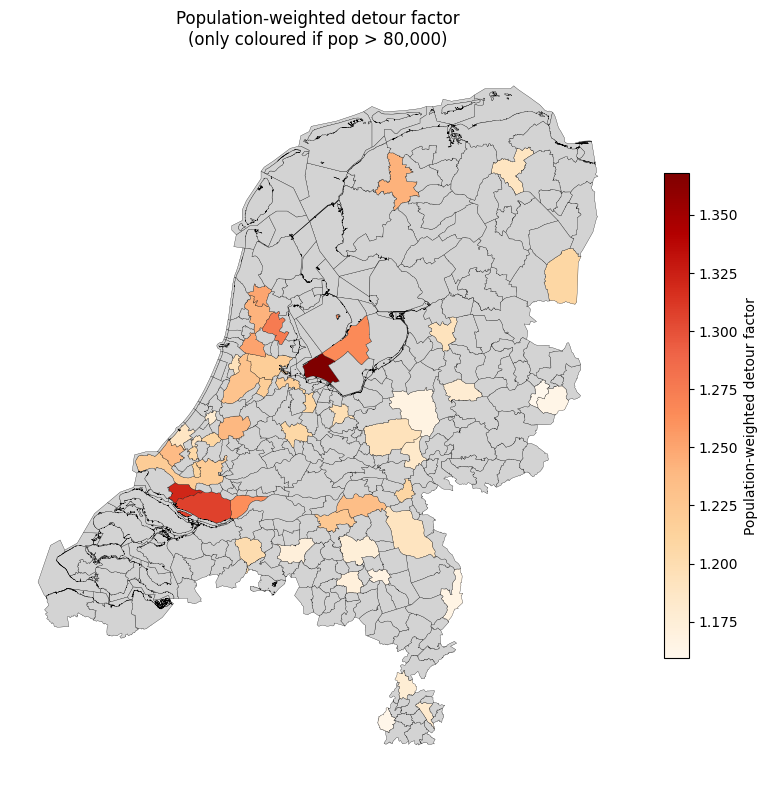

In [12]:
import numpy as np
from pathlib import Path
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from codebase.buurt_calculations import read_all_punt_to_punt
from codebase.data_loading.load_demographics import load_demograhics

def load_municipality_geometry(gpkg_path: Path) -> gpd.GeoDataFrame:
    gdf = gpd.read_file(gpkg_path, layer="gemeenten")
    gdf = (
        gdf[["gemeentenaam", "aantal_inwoners", "geometry"]]
        .rename(columns={"gemeentenaam": "gm_naam", "aantal_inwoners": "population"})
    )
    gdf["gm_naam"] = gdf["gm_naam"].str.title()
    return gdf

def weighted_detour_by_municipality(trips: pd.DataFrame, demo: pd.DataFrame) -> pd.DataFrame:
    merged = (
        trips
        .merge(demo[["gwb_code", "gm_naam", "a_inw"]],
               left_on="bu_code", right_on="gwb_code",
               how="left", validate="many_to_one")
        .dropna(subset=["a_inw"])
    )

    df_det = (
        merged.groupby("gm_naam")
              .apply(lambda x: (x["omrijdfactor"] * x["a_inw"]).sum() / x["a_inw"].sum())
              .reset_index(name="pop_weighted_detour")
    )
    df_det["gm_naam"] = df_det["gm_naam"].str.title()
    return df_det

def plot_detour_map(gdf: gpd.GeoDataFrame, pop_thresh: int):
    # mask out those below threshold, but keep geometry
    gdf["plot_detour"] = gdf["pop_weighted_detour"].where(gdf["population"] > pop_thresh)

    ax = gdf.plot(
        column="plot_detour",
        cmap="OrRd",
        edgecolor="black",
        linewidth=0.2,
        figsize=(8, 10),
        legend=True,
        legend_kwds={"label": "Population-weighted detour factor", "shrink": 0.5},
        missing_kwds={"color": "lightgrey", "label": f"pop ≤ {pop_thresh:,}"},
    )
    ax.set_title(
        f"Population-weighted detour factor\n"
        f"(only coloured if pop > {pop_thresh:,})",
        fontsize=12
    )
    ax.axis("off")
    plt.tight_layout()
    plt.savefig(
        f"graphics/detour_map_{pop_thresh}.png",
        dpi=300, bbox_inches="tight")
    plt.show()

def main(
            category: str = "basis",
    modes: tuple[str, ...] = ("fiets",),
    gpkg: Path = Path("data\WijkBuurtkaart_2023_v2\wijkenbuurten_2023_v2.gpkg"),
    out_csv: Path = Path("data/detour_result.csv"),
    min_population: int = 80000,
):
    # 1. load and concat all punt→buurt files
    matrices = read_all_punt_to_punt([category], list(modes))
    trips = pd.concat(matrices.values(), ignore_index=True)

    # 2. compute detour
    demo = load_demograhics()
    det  = weighted_detour_by_municipality(trips, demo)
    det.to_csv(out_csv, index=False)
    print(f"Saved CSV → {out_csv}")

    # 3. load geometry and merge
    gdf = load_municipality_geometry(gpkg).merge(det, on="gm_naam", how="left")

    # 4. plot with mask
    plot_detour_map(gdf, min_population)

# auto-run in notebook
if "__file__" not in globals():
    main()


In [14]:
# Load the merged gdf if not already in memory
gdf = load_municipality_geometry(Path("data\WijkBuurtkaart_2023_v2\wijkenbuurten_2023_v2.gpkg")).merge(
    pd.read_csv("data/detour_result.csv"), on="gm_naam", how="left"
)

# Filter to municipalities with population > 80,000
gdf_big = gdf[gdf["population"] > 80_000].copy()

# Remove NaNs if any
gdf_big = gdf_big.dropna(subset=["pop_weighted_detour"])

# Get Top 10 by detour factor
top_10 = gdf_big.sort_values("pop_weighted_detour", ascending=False).head(10)

# Print results
print("Top 10 municipalities (population > 80,000) with highest detour factor:")
for i, row in enumerate(top_10.itertuples(index=False), 1):
    print(f"{i}. {row.gm_naam}: detour={row.pop_weighted_detour:.3f}, population={int(row.population):,}")


Top 10 municipalities (population > 80,000) with highest detour factor:
1. Almere: detour=1.368, population=222,825
2. Nissewaard: detour=1.321, population=86,833
3. Hoeksche Waard: detour=1.308, population=89,760
4. Purmerend: detour=1.275, population=93,992
5. Lelystad: detour=1.266, population=83,033
6. Dordrecht: detour=1.263, population=121,434
7. Zaanstad: detour=1.251, population=159,618
8. Dijk En Waard: detour=1.250, population=88,985
9. Leeuwarden: detour=1.243, population=127,073
10. Alkmaar: detour=1.242, population=111,834


 ## Zoom in on municipalities with highest detour factor

Loading punt to punt data: 100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


Loaded file from CSV


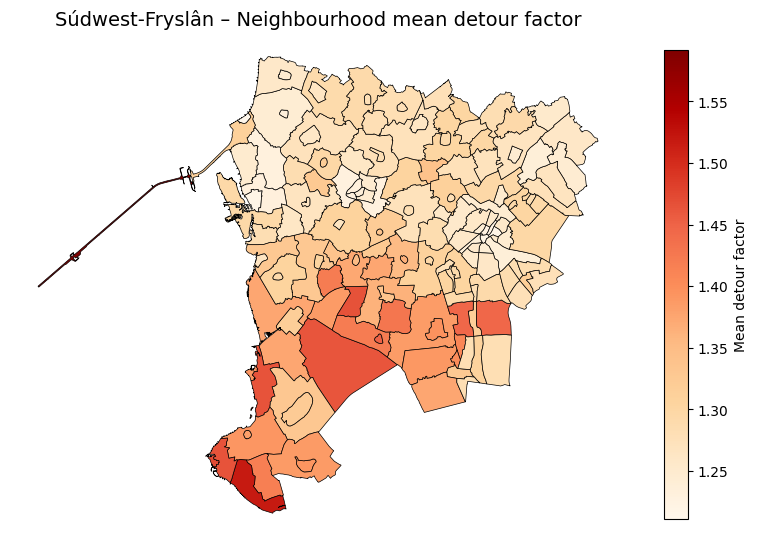

In [15]:


from codebase.buurt_calculations import read_all_punt_to_punt
from codebase.data_loading.load_demographics import load_demograhics
import pandas as pd

#  Filter to the buurt/wijk
gdf_neigh = gpd.read_file("data\WijkBuurtkaart_2023_v2\wijkenbuurten_2023_v2.gpkg", layer="buurten")  # or "buurt" or "wijk"
# Choose categories and modes
categories = ["basis"]  # or others if needed
modes = ["fiets"]       # or add "ebike", etc.

# Load and concatenate all punt -> buurt matrices
matrices = read_all_punt_to_punt(categories, modes)
trips = pd.concat(matrices.values(), ignore_index=True)

# Load demo table
demo = load_demograhics()
TARGET_MUN = "Súdwest-Fryslân"  #muncipality
buurtcodes_terneuzen = gdf_neigh[gdf_neigh["gemeentenaam"].str.title() == TARGET_MUN]["buurtcode"].unique()
trips_terneuzen = trips[trips["bu_code"].isin(buurtcodes_terneuzen)].copy()
demo_terneuzen = demo[demo["gwb_code"].isin(buurtcodes_terneuzen)].copy()

# Compute detour for these buurten
neigh_detour = (
    trips_terneuzen.merge(
        demo_terneuzen[["gwb_code", "a_inw"]],
        left_on="bu_code", right_on="gwb_code",
        how="left")
    .groupby("gwb_code", as_index=False)
    .agg(mean_detour=("omrijdfactor", "mean"),
         population=("a_inw", "first"))
)

# Rename and merge as before
neigh_detour_renamed = neigh_detour.rename(columns={'gwb_code': 'buurtcode'})
gdf_mun = gdf_neigh[gdf_neigh["gemeentenaam"].str.title() == TARGET_MUN].copy()
gdf_mun = gdf_mun.merge(neigh_detour_renamed, on="buurtcode", how="left")

# Plot
fig, ax = plt.subplots(figsize=(8, 7))
gdf_mun.plot(
    column="mean_detour",
    cmap="OrRd",
    legend=True,
    legend_kwds={"label": "Mean detour factor", "shrink": 0.7},
    edgecolor="black",
    linewidth=0.5,
    ax=ax
)
ax.set_title(f"{TARGET_MUN} – Neighbourhood mean detour factor", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.savefig(f"graphics/detour_map_{TARGET_MUN}.png", dpi=300, bbox_inches="tight")
plt.show()


In [17]:
# ------------------------------------------------------------------
# Build all prerequisite variables used later: trips, demo, det, gdf
# ------------------------------------------------------------------
from pathlib import Path
import pandas as pd
import geopandas as gpd
from codebase.buurt_calculations import read_all_punt_to_punt
from codebase.data_loading.load_demographics import load_demograhics

# a. parameters
CATEGORY = "trein"
MODES    = ("fiets",)
GPKG     = Path("data\WijkBuurtkaart_2023_v2\wijkenbuurten_2023_v2.gpkg")

# b. trips
matrices = read_all_punt_to_punt([CATEGORY], list(MODES))
trips    = pd.concat(matrices.values(), ignore_index=True)

# c. demo
demo = load_demograhics()

# d. detour per gemeente
det = weighted_detour_by_municipality(trips, demo)

# e. geometry + merge
gdf = load_municipality_geometry(GPKG).merge(det, on="gm_naam", how="left")

print("Ready: trips, demo, det, gdf")
gdf_neigh = gpd.read_file("data\WijkBuurtkaart_2023_v2\wijkenbuurten_2023_v2.gpkg", layer="buurten")  # or "buurt" or "wijk"
gdf_neigh["gwb_code"] = gdf_neigh["buurtcode"]  # Ensure gwb_code is available for merging
# inspect columns:
print(gdf_neigh.columns)

# We'll assume there is a 'gwb_code' and 'gm_naam' column in gdf_neigh

TARGET_MUN = "Terneuzen"  # or any gm_naam you want

# Filter to only neighbourhoods in the selected municipality
gdf_mun = gdf_neigh[gdf_neigh["gemeentenaam"].str.title() == TARGET_MUN].copy()

# Merge with detour factors
gdf_mun = gdf_mun.merge(neigh_detour, on="gwb_code", how="left")


Loading punt to punt data: 100%|██████████| 1/1 [00:00<00:00,  8.24it/s]


Loaded file from CSV


C:\Users\toell\AppData\Local\Temp\ipykernel_22208\831888282.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x["omrijdfactor"] * x["a_inw"]).sum() / x["a_inw"].sum())


Ready: trips, demo, det, gdf
Index(['buurtcode', 'buurtnaam', 'wijkcode', 'gemeentecode', 'gemeentenaam',
       'indelingswijziging_wijken_en_buurten', 'water',
       'meest_voorkomende_postcode', 'dekkingspercentage',
       'omgevingsadressendichtheid',
       ...
       'afstand_tot_semiopenbaar_groen_totaal', 'afstand_tot_sportterrein',
       'afstand_tot_volkstuin', 'afstand_tot_verblijfsrecreatief_terrein',
       'afstand_tot_recreatief_binnenwater', 'afstand_tot_begraafplaats',
       'jrstatcode', 'jaar', 'geometry', 'gwb_code'],
      dtype='object', length=225)


## What share of these residents already lives within 30 min bike time as-the-crow-flies but exceeds 30
min on the actual network? (To key destinations, like trein, basis, mbo etc)

In [18]:
BIKE_SPEED = 21  # km/h
KMH_TO_M_PER_MIN = 1000 / 60 * BIKE_SPEED  # not needed, see below

# Crow-flies time in minutes (distance in meters → km → min)
trips["time_crow"] = (trips["afstand_hemelsbreed_m"] / 1000) / BIKE_SPEED * 60

# Network time is already present!
trips["time_net"] = trips["reistijd_min"]


In [19]:
# 2. aggregate to neighbourhood level (mean time per origin buurt)
time_per_buurt = (
    trips.groupby("bu_code", as_index=False)
         .agg(time_crow=("time_crow", "mean"),
              time_net =("time_net",  "mean"))
         .rename(columns={"bu_code": "buurtcode"})
)

# 3. add population
time_pop = time_per_buurt.merge(
    demo.rename(columns={"gwb_code": "buurtcode"})[["buurtcode", "a_inw"]],
    on="buurtcode", how="left"
)

# 4. (optional) add gemeente label for filtering
time_pop = time_pop.merge(
    gdf_neigh[["buurtcode", "gemeentenaam"]],
    on="buurtcode", how="left"
)


## Check per muncipality

In [20]:
TARGET_MUN = "Súdwest-Fryslân"

df_mun = time_pop[time_pop["gemeentenaam"].str.title() == TARGET_MUN]

within_30_crow = df_mun[df_mun["time_crow"] <= 30]
detour_residents = within_30_crow[within_30_crow["time_net"] > 30]

share = detour_residents["a_inw"].sum() / within_30_crow["a_inw"].sum()
print(f"{share:.1%} of residents in {TARGET_MUN} live ≤30min crow-flies but >30min on the network.")


nan% of residents in Súdwest-Fryslân live ≤30min crow-flies but >30min on the network.


C:\Users\toell\AppData\Local\Temp\ipykernel_22208\60364296.py:8: RuntimeWarning: invalid value encountered in scalar divide
  share = detour_residents["a_inw"].sum() / within_30_crow["a_inw"].sum()


## Check for whole netherlands

Top 10 municipalities with highest share of residents within 30 min crow-flies but >30 min on the network:
1. Beek: 100.0% (4,500 / 4,500 residents)
2. Beekdaelen: 100.0% (18,855 / 18,855 residents)
3. Emmen: 100.0% (405 / 405 residents)
4. Heerlen: 100.0% (20,240 / 20,240 residents)
5. Veere: 100.0% (4,885 / 4,885 residents)
6. Middelburg: 100.0% (40,175 / 40,175 residents)
7. Reimerswaal: 100.0% (5,545 / 5,545 residents)
8. Valkenburg aan de Geul: 100.0% (3,840 / 3,840 residents)
9. Vlissingen: 100.0% (30,115 / 30,115 residents)
10. Venlo: 100.0% (13,520 / 13,520 residents)


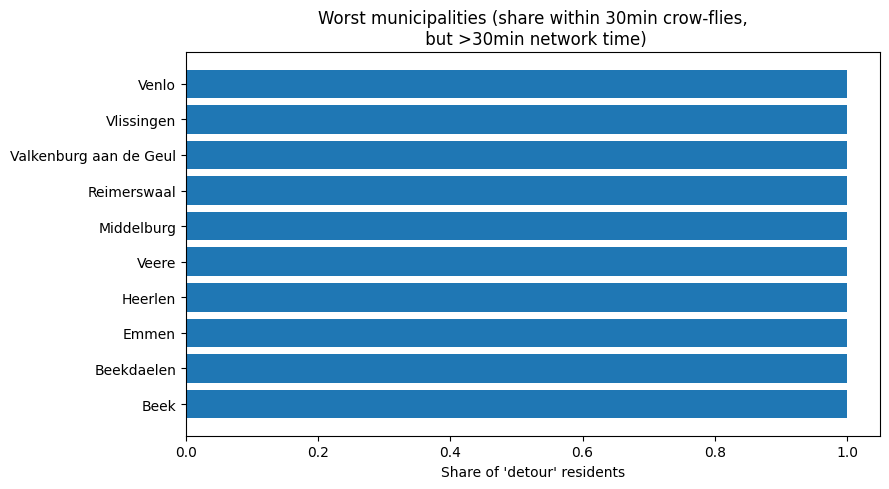

In [21]:
# Only keep buurten with valid data
valid = time_pop.dropna(subset=["gemeentenaam", "time_crow", "time_net", "a_inw"]).copy()

# Only buurten within 30 min crow-flies
within_30 = valid[valid["time_crow"] <= 30].copy()

# For those, which buurten exceed 30 min on the network?
within_30["detour_flag"] = within_30["time_net"] > 30

# Group per municipality
result = (
    within_30.groupby("gemeentenaam")
    .agg(
        pop_crow=("a_inw", "sum"),
        pop_detour=("detour_flag", lambda x: within_30.loc[x.index, "a_inw"][x].sum())
    )
    .assign(share=lambda d: d["pop_detour"] / d["pop_crow"])
    .dropna(subset=["share"])
    .query("pop_crow > 0")
    .sort_values("share", ascending=False)
)

# Print top 10 "worst" municipalities
top10 = result.head(10).reset_index()
print("Top 10 municipalities with highest share of residents within 30 min crow-flies but >30 min on the network:")
for i, row in top10.iterrows():
    print(f"{i+1}. {row['gemeentenaam']}: {row['share']:.1%} ({int(row['pop_detour']):,} / {int(row['pop_crow']):,} residents)")

# (Optional) plot bar chart
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(9, 5))
ax.barh(top10["gemeentenaam"], top10["share"])
ax.set_xlabel("Share of 'detour' residents")
ax.set_title("Worst municipalities (share within 30min crow-flies,\n but >30min network time)")
plt.tight_layout()
plt.show()


In [22]:
print("Total buurten in time_pop:", len(time_pop))
print("Buurten with time_crow <= 30:", (time_pop["time_crow"] <= 30).sum())
print("Buurten with time_crow <= 30 AND time_net > 30:", ((time_pop["time_crow"] <= 30) & (time_pop["time_net"] > 30)).sum())


Total buurten in time_pop: 14360
Buurten with time_crow <= 30: 192
Buurten with time_crow <= 30 AND time_net > 30: 183


In [23]:
print(time_pop[["gemeentenaam", "time_crow", "time_net", "a_inw"]].sample(10))



      gemeentenaam  time_crow   time_net   a_inw
2630        Elburg  48.399388  70.071429   940.0
5368         Hoorn  45.546476  66.333333     5.0
3764         Soest  46.557736  69.264151   165.0
14287    Maashorst  61.693571  95.428571   370.0
502     Heerenveen  54.295429  82.000000  3265.0
1407      Deventer  48.023602  66.260870   240.0
10787   Westerveld  44.114286  62.800000   155.0
10165   Koggenland  49.354629  73.680000   345.0
4704     Amsterdam  50.575952  74.650000  2520.0
13405       Altena  52.511299  85.045455   130.0


In [24]:
print("Any NaN in time_crow?", time_pop["time_crow"].isna().sum())
print("Any NaN in time_net?", time_pop["time_net"].isna().sum())


Any NaN in time_crow? 0
Any NaN in time_net? 0


In [25]:
# Assume 'trips' has one row per OD pair: origin = bu_code, destination = <punt_type>
# and columns 'afstand_hemelsbreed_m', 'reistijd_min' etc.

BIKE_SPEED = 21  # km/h
trips["time_crow"] = (trips["afstand_hemelsbreed_m"] / 1000) / BIKE_SPEED * 60
trips["time_net"] = trips["reistijd_min"]

# For each buurt, get the MINIMUM time to any key destination (e.g. any "trein" station)
# Suppose you filter trips for one category first:
# trips_filtered = trips[trips["punt_type"] == "trein"]   # adjust as needed

# Now group by origin buurt:
time_min_per_buurt = (
    trips.groupby("bu_code", as_index=False)
         .agg(time_crow_min=("time_crow", "min"),
              time_net_min =("time_net",  "min"))
         .rename(columns={"bu_code": "buurtcode"})
)

# Add population and gemeente label:
time_min_pop = time_min_per_buurt.merge(
    demo.rename(columns={"gwb_code": "buurtcode"})[["buurtcode", "a_inw"]],
    on="buurtcode", how="left"
).merge(
    gdf_neigh[["buurtcode", "gemeentenaam"]],
    on="buurtcode", how="left"
)

# Now use the earlier logic:
within_30 = time_min_pop[time_min_pop["time_crow_min"] <= 30].copy()
within_30["detour_flag"] = within_30["time_net_min"] > 30

result = (
    within_30.groupby("gemeentenaam")
    .agg(
        pop_crow=("a_inw", "sum"),
        pop_detour=("detour_flag", lambda x: within_30.loc[x.index, "a_inw"][x].sum())
    )
    .assign(share=lambda d: d["pop_detour"] / d["pop_crow"])
    .dropna(subset=["share"])
    .query("pop_crow > 0")
    .sort_values("share", ascending=False)
)

top10 = result.head(10).reset_index()
print(top10)


        gemeentenaam  pop_crow  pop_detour  share
0  West Maas en Waal   20065.0     20065.0    1.0
1           Waalwijk    1250.0      1250.0    1.0
2           Bergeijk     220.0       220.0    1.0
3              Vaals    9640.0      9640.0    1.0
4           Uithoorn   31440.0     31440.0    1.0
5              Texel     780.0       780.0    1.0
6        Stadskanaal    3170.0      3170.0    1.0
7              Sluis    7595.0      7595.0    1.0
8   Ooststellingwerf     295.0       295.0    1.0
9    Noordoostpolder    1245.0      1245.0    1.0


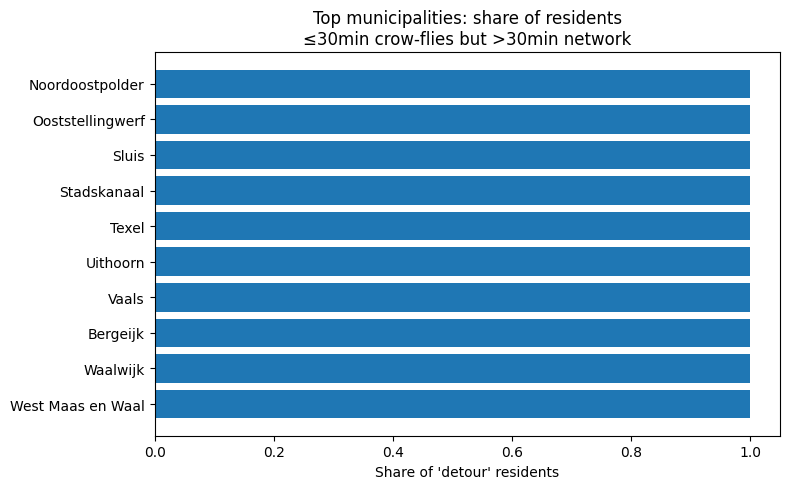

In [26]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 5))
ax.barh(top10["gemeentenaam"], top10["share"])
ax.set_xlabel("Share of 'detour' residents")
ax.set_title("Top municipalities: share of residents\n≤30min crow-flies but >30min network")
plt.tight_layout()
plt.show()
